In [1]:
from PIL import Image,ImageStat
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time
import io
import math
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from imutils.perspective import four_point_transform
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

square = np.ones((2,2))
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

blackPoint = 66
whitePoint = 127
test_img = None
def si(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    return

def map(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def isBright(img):
    blur = cv2.blur(img, (4, 4))  # With kernel size depending upon image size
    if cv2.mean(blur)[0] > 127:  # The range for a pixel's value in grayscale is (0-255), 127 lies midway
        return 1 # (127 - 255) denotes light image
    else:
        return 0

def brightnessControl(image, level):
    return cv2.convertScaleAbs(image, beta=level)


def highPassFilter(img,kSize):
    if not kSize%2:
        kSize +=1
        
    kernel = np.ones((kSize,kSize),np.float32)/(kSize*kSize)
    filtered = cv2.filter2D(img,-1,kernel)
    filtered = img.astype('float32') - filtered.astype('float32')
    filtered = filtered + 127*np.ones(img.shape, np.uint8)
    filtered = filtered.astype('uint8')
    img = filtered
    return img

    
def blackPointSelect(img):
    img = img.astype('int32')
    img = map(img, blackPoint, 255, 0, 255)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_TOZERO)
    img = img.astype('uint8')
    return img

    
def whitePointSelect(img):
    _,img = cv2.threshold(img, whitePoint, 255, cv2.THRESH_TRUNC)
    img = img.astype('int32')
    img = map(img, 0, whitePoint, 0, 255)
    img = img.astype('uint8')
    return img

def blackAndWhite(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    (l,a,b) = cv2.split(lab)
    img = cv2.add( cv2.subtract(l,b), cv2.subtract(l,a) )
    return img


def final_crop(img):
    _,img = cv2.threshold(img,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    polygon = contours[0]
    sums = []
    diffs = []

    for point in polygon:
        for x, y in point:
            sums.append(x + y)
            diffs.append(x - y)

    top_left = polygon[np.argmin(sums)].squeeze()
    bottom_right = polygon[np.argmax(sums)].squeeze() 
    top_right = polygon[np.argmax(diffs)].squeeze()
    bottom_left = polygon[np.argmin(diffs)].squeeze() 

    coords = np.array([top_left, top_right, bottom_left, bottom_right], dtype = np.float32)
    return coords

def sudokuCleaner(img):
    print('chckbright',isBright(img))
    if isBright(img):
#         t1 = blackPointSelect(img)
#         t1 = whitePointSelect(t1)
        t1=255-img
        thr1 = cv2.adaptiveThreshold(t1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,111,2)
        thr1=255-thr1
#         kernel = np.ones((1,1))
#         kernel1 = np.ones((3,3))
#         p1 = cv2.erode(thr1,kernel)
#         p1 = cv2.dilate(p1,kernel1)
        return thr1
#         self.image = cv2.GaussianBlur(self.image,(5,5),cv2.BORDER_DEFAULT)
    else:
        whitePoint=160
        img = whitePointSelect(img)
        img = blackPointSelect(img)
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,111,2)
        kernel = np.ones((2,2))
        kernel1 = np.ones((1,1))
        img = cv2.erode(img,kernel)
        t1 = cv2.dilate(img,kernel)
        print('clean magic')
        si(t1)
        return t1
#     t1 = blackPointSelect(brightnessControl(img,-30))
#     t1 = whitePointSelect(t1)
    
    
    
def getSudokuSize(img):
#     img = cv2.cvtColor(cv2.imread('./mod_image.png'), cv2.COLOR_BGR2GRAY)
    hor = 255-img
    ver = 255-img
    hor = cv2.threshold(cv2.blur(hor, (1,100)), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = np.ones((100,1))
    hor = cv2.morphologyEx(hor,cv2.MORPH_OPEN,kernel)
    hor=multi_dil(hor,1)
    ver = cv2.threshold(cv2.blur(ver, (100,1)), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = np.ones((1,100))
    ver = cv2.morphologyEx(ver,cv2.MORPH_OPEN,kernel)
    ver=multi_dil(ver,1)
    res = cv2.bitwise_and(hor,ver)
    res = cv2.dilate(res,square)
    contours, hierarchy = cv2.findContours(res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return int(math.sqrt(len(contours))-1)

class SudokuPreprocessor:
    
    def __init__(self,path):
        self.ext = path.split('.')[-1]
        self.digitArea = 0
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        self.original = self.image.copy()
#         print('Original Image')
#         si(self.image)
#         self.image = brightnessControl(self.image,-100)
        if isBright(self.image):
            self.image = cv2.GaussianBlur(self.image,(5,5),cv2.BORDER_DEFAULT)
        else:
            self.image = highPassFilter(self.image,kSize = 5)
            self.image = whitePointSelect(self.image)
            self.image = blackPointSelect(self.image)
#             print('Magic Filters Image')
#         si(self.image)
        if self.ext == 'png':
            pass
        else:
            path = path.replace('.'+self.ext,'.png')
        self.all_contours =  []
        self.mod_image = ""
        self.image_name = path.replace('.'+self.ext,'.png')
        self.image_dir_path = path[:len(self.image_name)]
    
    def ignite(self):
        
        coords = self.getCoords()
        dest = np.float32([[0,0],[300,0],[0,300],[300,300]])
        self.mod_image = self.sudokuExtractor(coords,dest)
#         final_coords = final_crop(self.mod_image.copy())
#         si(self.mod_image)
        
        cv2.imwrite('mod_image.png',self.mod_image)
#         print(coords,final_coords)
#         self.mod_image = self.sudokuExtractor(final_coords,dest,True)
#         print('Extracted Image')
#         si(self.mod_image)
#         test_img = self.mod_image
#         cv2.imwrite('mod_image.png',self.mod_image)
#         kernel = np.ones((3,3),np.uint8)
#         self.mod_image = cv2.morphologyEx(self.mod_image, cv2.MORPH_OPEN, kernel)
        self.mod_image = sudokuCleaner(self.mod_image)
        si(self.mod_image)
        cv2.imwrite('mod_image.png',self.mod_image)
        self.sudoku_size = getSudokuSize(self.mod_image.copy())
        self.upscaler()
        self.mod_image = self.ImagePadder(Image.open(self.image_name),pad=0)
        print('Upscaled Image')
        si(self.mod_image)
        return self.getMatrix()
    
    
    def resizer(self,fin):
        with open(fin, 'r') as file :
            filedata = file.read()
        filedata = filedata.replace('width="300.000000pt" height="300.000000pt"', 'width="1200.000000pt" height="1200.000000pt"')
        with open(fin, 'w') as file:
            file.write(filedata)
            
    def upscaler(self):
        con = cv2.imencode('.png', self.mod_image)[1].tobytes()
        temp = Image.open(io.BytesIO(con))
        file_out = "temp.bmp"
        temp.save(file_out)
        os.system('potrace temp.bmp --svg -o temp.svg')
        self.resizer('temp.svg')
        os.system(f'cairosvg temp.svg -o {self.image_name}')
        # os.remove(f'{self.image_dir_path}temp.svg')

    def getCoords(self):
        img_copy = self.image.copy()
        thresh3 = cv2.adaptiveThreshold(img_copy,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
        thresh3 = (255-thresh3)
        contours, _ = cv2.findContours(thresh3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key = cv2.contourArea, reverse = True)
        polygon = contours[0]
        sums = []
        diffs = []

        for point in polygon:
            for x, y in point:
                sums.append(x + y)
                diffs.append(x - y)

        top_left = polygon[np.argmin(sums)].squeeze()
        bottom_right = polygon[np.argmax(sums)].squeeze() 
        top_right = polygon[np.argmax(diffs)].squeeze()
        bottom_left = polygon[np.argmin(diffs)].squeeze() 

        coords = np.array([top_left, top_right, bottom_left, bottom_right], dtype = np.float32)
        return coords
    
    def sudokuExtractor(self,start,dest,isFinal=False):
        perspective_transform = cv2.getPerspectiveTransform(start,dest)
        if isFinal:
            print('inside ext')
            si(self.mod_image)
            img_Output = cv2.warpPerspective(255-self.mod_image.copy(),perspective_transform,(300,300))
            print('inside ext1')
            si(self.mod_image)
            print('inside ext2')
            si(img_Output)
        else:
            img_Output = cv2.warpPerspective(self.original,perspective_transform,(300,300))
        print('inside ext3')
        si(img_Output)
        return img_Output
    
    def remove_transparency(self,im, bg_colour=(255, 255, 255)):
        if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
            alpha = im.convert('RGBA').split()[-1]
            bg = Image.new("RGBA", im.size, bg_colour + (255,))
            bg.paste(im, mask=alpha)
            return bg
        else:
            return im

    def ImagePadder(self,img,pad=20):
        if type(img) is np.ndarray:
            pass
        else:
            img = self.remove_transparency(img).convert('L')
            img = np.array(img)
        _,img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
        data = np.full((img.shape[0],img.shape[1]), 255,dtype=np.uint8)
        data[pad:img.shape[0] - pad,pad:img.shape[1]-pad] = img[pad:img.shape[0] - pad,pad:img.shape[1]-pad]
        return data

    def is_CellEmpty(self,img):
        return np.all(self.ImagePadder(img,pad=60) == 255)
    

    def getMatrix(self):
        size = self.sudoku_size
        width = int(self.mod_image.shape[0]/size)
        k=0
        cell = [0]*((size)**2)
        cell_area = []
        sudoku = [-1]*(size)**2
        area = 0
        contains_digit = []
        for x in range(size):
            for y in range(size):
                t1 = self.mod_image[width*x : width*(x+1), width*y : width*(y+1)]
                t1 = self.ImagePadder(t1,pad=15)
                
                cell[k] = t1.copy()
                t1 = cv2.bitwise_not(t1)
                contours, _ = cv2.findContours(t1,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                contours = sorted(contours, key = cv2.contourArea, reverse = True)
                for c in contours[1:]:
                    cell[k] = cv2.fillPoly(cell[k], [c], color=(255,255,255))
                if self.is_CellEmpty(cell[k]):
                    sudoku[k]=0
                    cell[k]=0
                else:
                    contains_digit.append(k)
                    ca = cv2.contourArea(contours[0])
                    area+=ca
                    cell_area.append(ca)
                k+=1
        median_area = np.median(cell_area)
        temp_idx = []
        for idx in range(len(cell_area)):
            if cell_area[idx] <= median_area*0.5:
                remove_digit_idx = contains_digit[idx]
                sudoku[remove_digit_idx] = 0
                cell[remove_digit_idx] = 0
                temp_idx.append(idx)
        contains_digit = np.delete(contains_digit, temp_idx)
        return cell, sudoku, contains_digit

inside ext3


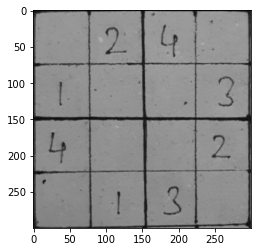

chckbright 1


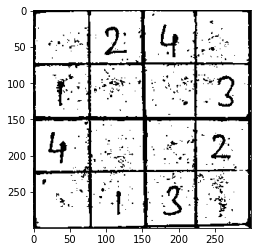

Upscaled Image


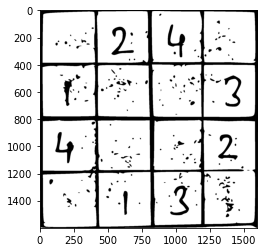

In [14]:
cell, sudoku, digit_idx = SudokuPreprocessor('./44.jpeg').ignite()

In [15]:
k=0
valid = []
model_files = []
for c in cell:
    if str(type(c)) != "<class 'int'>":
#         si(c)
        valid.append(k)
        model_files.append(np.expand_dims(cv2.resize(c, (28, 28)), axis=-1))
    k+=1

In [16]:
from keras.models import load_model

model = load_model('final.h5')

In [17]:
# len(model_files)

In [18]:
    def resizer(fin):
        with open(fin, 'r') as file :
            filedata = file.read()
        filedata = filedata.replace('width="266.000000pt" height="266.000000pt"', 'width="21.000000pt" height="21.000000pt"')
        with open(fin, 'w') as file:
            file.write(filedata)
            
    def upscaler(mod_image,image_name):
        con = cv2.imencode('.png', mod_image)[1].tobytes()
        temp = Image.open(io.BytesIO(con))
        file_out = "temp.bmp"
        temp.save(file_out)
        os.system('potrace temp.bmp --svg -o temp.svg')
        resizer('temp.svg')
        os.system(f'cairosvg temp.svg -o {image_name}')
    def remove_transparency(im, bg_colour=(255, 255, 255)):
        if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
            alpha = im.convert('RGBA').split()[-1]
            bg = Image.new("RGBA", im.size, bg_colour + (255,))
            bg.paste(im, mask=alpha)
            print('hii')
            return bg
        else:
            return im

In [19]:
for v,m in zip(valid,model_files):
    imgs = m
    imgs = 255-imgs
    imgs = imgs.reshape(-1,28,28,1)
    sudoku[v]= np.argmax(model.predict(imgs))

# Backtracking Algorithm

In [20]:
# 4x4
# 6x6         box(2x3)
# 9x9
# 12x12     box(3x4)
# 16x16

VALID_SIZE = [4, 6, 9, 12, 16]
BOX_SIZE = {
    4: [2, 2],
    6: [2, 3],
    9: [3, 3],
    12: [3, 4],
    16: [4, 4],
}

def used_in_row(grid:list, row:int, num:int) -> bool:
    for i in range(len(grid)):
        if grid[row][i] == num:
            return True
    return False

def used_in_col(grid:list, col:int, num:int) -> bool:
    for i in range(len(grid)):
        if grid[i][col] == num:
            return True
    return False

def used_in_box(grid:list, row:int, col:int, width:int, height:int, num:int) -> bool:
    for i in range(height):
        for j in range(width):
            if grid[row+i][col+j] == num:
                return True
    return False

def find_empty(grid:list) -> bool:
    for i in range(len(grid)):
        for j in range(len(grid)):
            if grid[i][j] == 0:
                return [i, j]
    return False

def check_location(grid:list, row:int, col:int, width:int, height:int, num:int):
    return not used_in_row(grid, row, num)\
        and not used_in_col(grid, col, num)\
        and not used_in_box(grid, row-row%height, col-col%width, width, height, num)

def solve_sudoku_bt(grid:list, box_width:int, box_height:int):
    loc = find_empty(grid)
    if not loc:
        return True
    row, col = loc
    for num in range(1, len(grid)+1):
        if check_location(grid, row, col, box_width, box_height, num):
            grid[row][col] = num
            if solve_sudoku_bt(grid, box_width, box_height):
                return True
            grid[row][col] = 0
    return False

def solve_sudoku(grid:list):
    height = len(grid)
    width = len(grid[0])
    if height == width and height in VALID_SIZE:
        # format is correct, try solving
        box_height, box_width = BOX_SIZE[height]
        if solve_sudoku_bt(grid, box_width, box_height):
            return grid
        else:
            print('This sudoku can not be solved.')
            return False
    else:
        print('This sudoku can not be solved.')
        return False

In [21]:
sud = np.reshape(sudoku, (int(math.sqrt(len(sudoku))), int(math.sqrt(len(sudoku)))))

In [22]:
print(solve_sudoku(sud))

[[3 2 4 1]
 [8 4 2 3]
 [4 1 3 2]
 [2 3 1 4]]
